# Load data using dataframe.

In [192]:
import numpy as np
import pandas as pd
from scipy.signal import detrend

import matplotlib.pyplot as plt
import seaborn as sns

import neurokit2 as nk

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn import tree


from sklearn.model_selection import cross_val_score

import graphviz 


import os

In [193]:

def convert_units(data):
    eda = (data / 2**10) * 3.3 / 0.12
    return eda


In [194]:
# Load data in file Data/Session_3.csv into a pandas dataframe  

# Load data from file
data = pd.read_csv(os.path.join('Data','Session_2.csv'))

# Sampling freq.
fs = 1000

# Display the data
data.head()

data['EDA'] = convert_units(data['EDA'])

# remove mean and trend from Resp
data['Resp'] = detrend(data['Resp'])




# Trigger management 
Transform p into -1 , and remove excess of 0 and 1 

In [195]:
# change value in position i in Trigger column to -1.0 if the value in  sample i-1 was 'p', '0', or '1'



# Create a list of the indexes of the rows that need to be changed
indexes_to_change = []
for i in range(1, len(data)):
    if data.loc[i-1, 'Trigger'] in ['p', '0', '1']:
        indexes_to_change.append(i)

# Change the values in the Trigger column
data.loc[indexes_to_change, 'Trigger'] = '-1.0'

# change p in Trigger column to 9.0
data.loc[data['Trigger'] == 'p', 'Trigger'] = '-1.0'


# Convert the values in the Trigger column to float
data['Trigger'] = data['Trigger'].astype(float)

# get trigger values above -1
trigger_values = data[data['Trigger'] > -1.0]['Trigger']


print(len(trigger_values))



20


# Data visualization

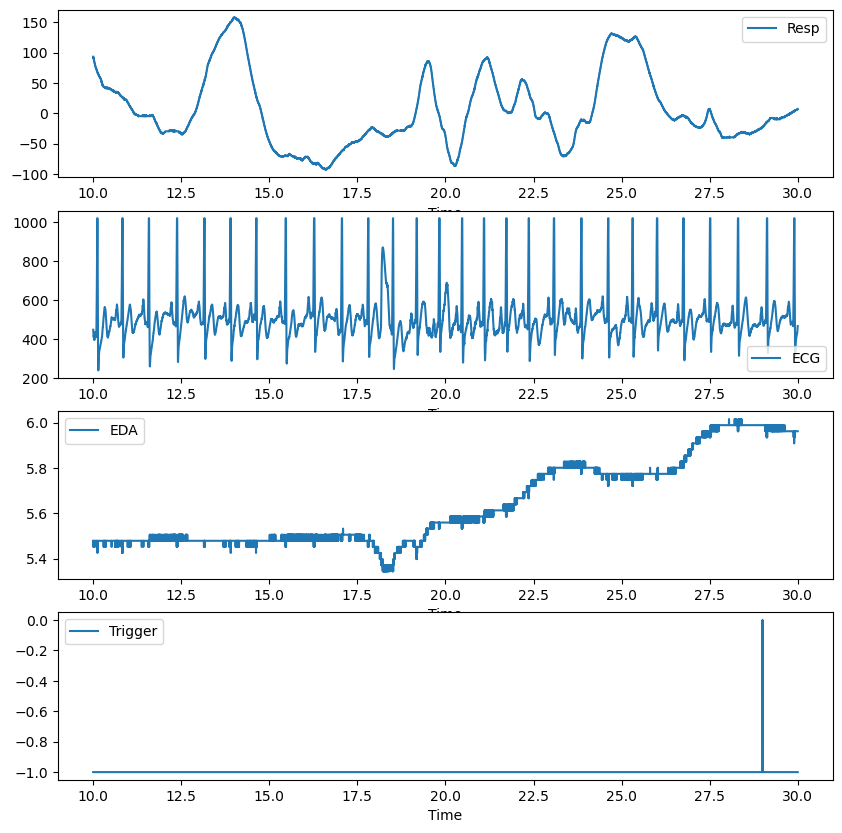

In [196]:
# plot the data, x-axis is the first column, subplots for the second, third and fourth column

offset=10000
wSize=20000

# figure with 3 subplots only show 10 seconds of data
fig, axs = plt.subplots(4, 1, figsize=(10, 10))

# plot the data
data.iloc[offset:offset+wSize].plot(x='Time', y='Resp', ax=axs[0])
data.iloc[offset:offset+wSize].plot(x='Time', y='ECG', ax=axs[1])
data.iloc[offset:offset+wSize].plot(x='Time', y='EDA', ax=axs[2])
data.iloc[offset:offset+wSize].plot(x='Time', y='Trigger', ax=axs[3])

# show the plot
plt.show()



# Extract epochs

In [197]:
# Segment data using column trigger

# find the indices where the trigger is 1 or 0
triggers = (data['Trigger'] == 1) | (data['Trigger'] == 0)
indices = np.where(triggers)[0]

# Epoch size in samples
ePreSize= 4*fs
ePosSize= 16*fs

# Segment the data into Epochs
epochs = []
for i in range(len(indices)):
    epochs.append(data.iloc[indices[i]-ePreSize:indices[i]+ePosSize])

num_epochs = len(epochs)
print(num_epochs)


20


# Resp features.

In [198]:
# compute average of segments
rMean = []
rSD = []
rMax = []
rMin = []

for ep in epochs:
    rMean.append(ep['Resp'][ePreSize:].mean()/ep['Resp'][:ePreSize].mean())
    rSD.append(ep['Resp'][ePreSize:].std()/ep['Resp'][:ePreSize].std())
    rMax.append(ep['Resp'][ePreSize:].max()/ep['Resp'][:ePreSize].max())
    rMin.append(ep['Resp'][ePreSize:].min()/ep['Resp'][:ePreSize].min())

    

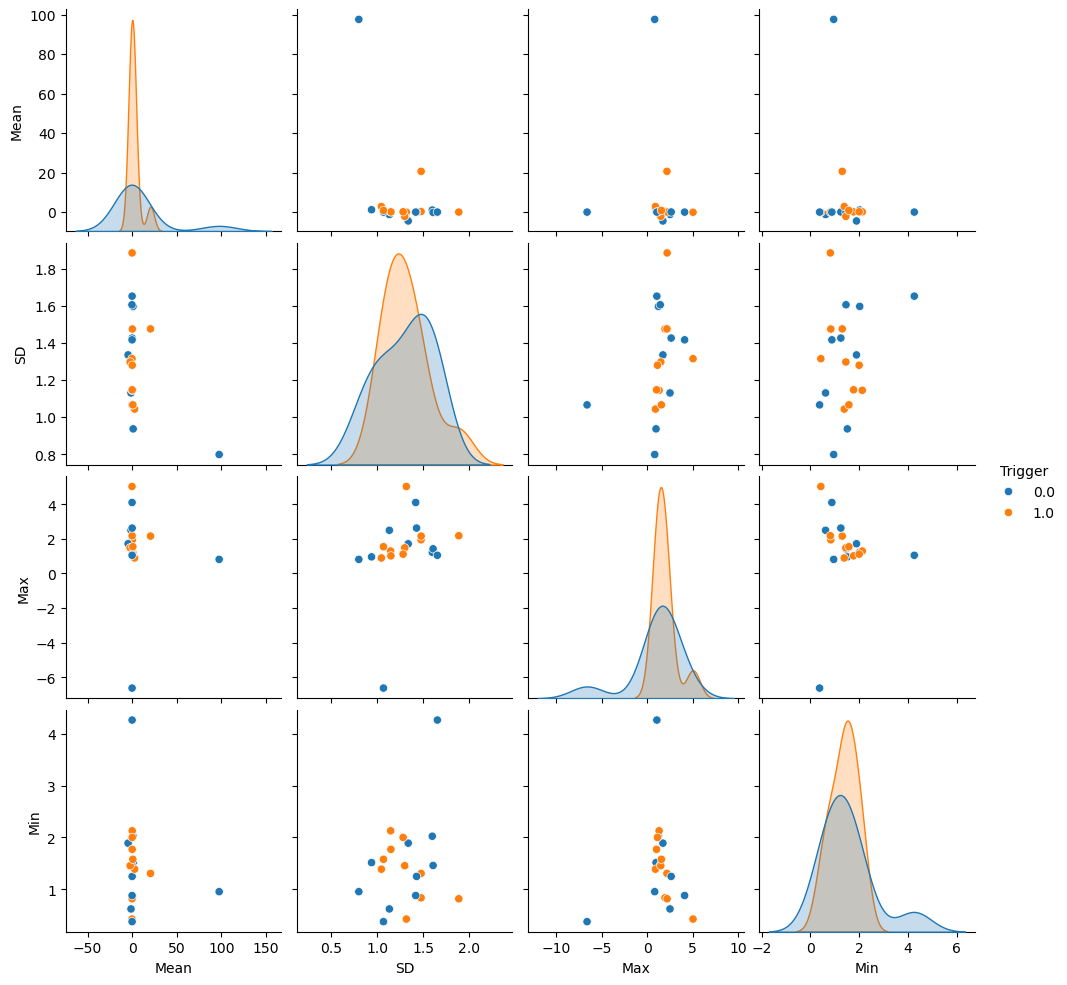

In [199]:
# show feature  grouped by trigger_values 0 and 1 using seaborn 
df = pd.DataFrame({'Mean': rMean, 'SD': rSD, 'Max': rMax, 'Min': rMin, 'Trigger': trigger_values})

sns.pairplot(df, hue='Trigger')
plt.show()

# EDA features.

In [200]:

# Load data from file
eda = data['EDA']

# compute the EDA features
eda_features = nk.eda_process(eda, sampling_rate=1000)


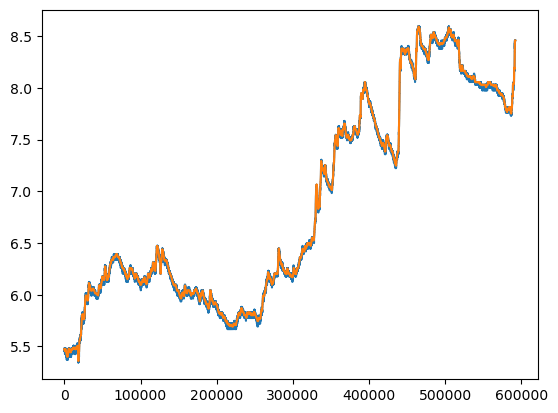

In [201]:
eda_features[0]['EDA_Raw'].plot()
eda_features[0]['EDA_Clean'].plot()
plt.show()


In [202]:


# Segment data using column trigger

# find the indices where the trigger is 1 or 0
triggers = (data['Trigger'] == 1) | (data['Trigger'] == 0)
indices = np.where(triggers)[0]

# Epoch size in samples

preSize= 4*fs
posSize= 16*fs

# Segment the data into Epochs
epochs = []
for i in range(len(indices)):
    epochs.append(eda_features[0].iloc[indices[i]-preSize:indices[i]+posSize])

num_epochs = len(epochs)
print(num_epochs)



20


In [203]:
# compute average of segments
edaMean = []
edaSD = []
edaMax = []
edaMin = []


for ep in epochs:
    edaMean.append(ep['EDA_Clean'][preSize:].mean()/ep['EDA_Clean'][:preSize].mean())
    edaSD.append(ep['EDA_Clean'][preSize:].std()/ep['EDA_Clean'][:preSize].std())
    edaMax.append(ep['EDA_Clean'][preSize:].max()/ep['EDA_Clean'][:preSize].max())
    edaMin.append(ep['EDA_Clean'][preSize:].min()/ep['EDA_Clean'][:preSize].min())

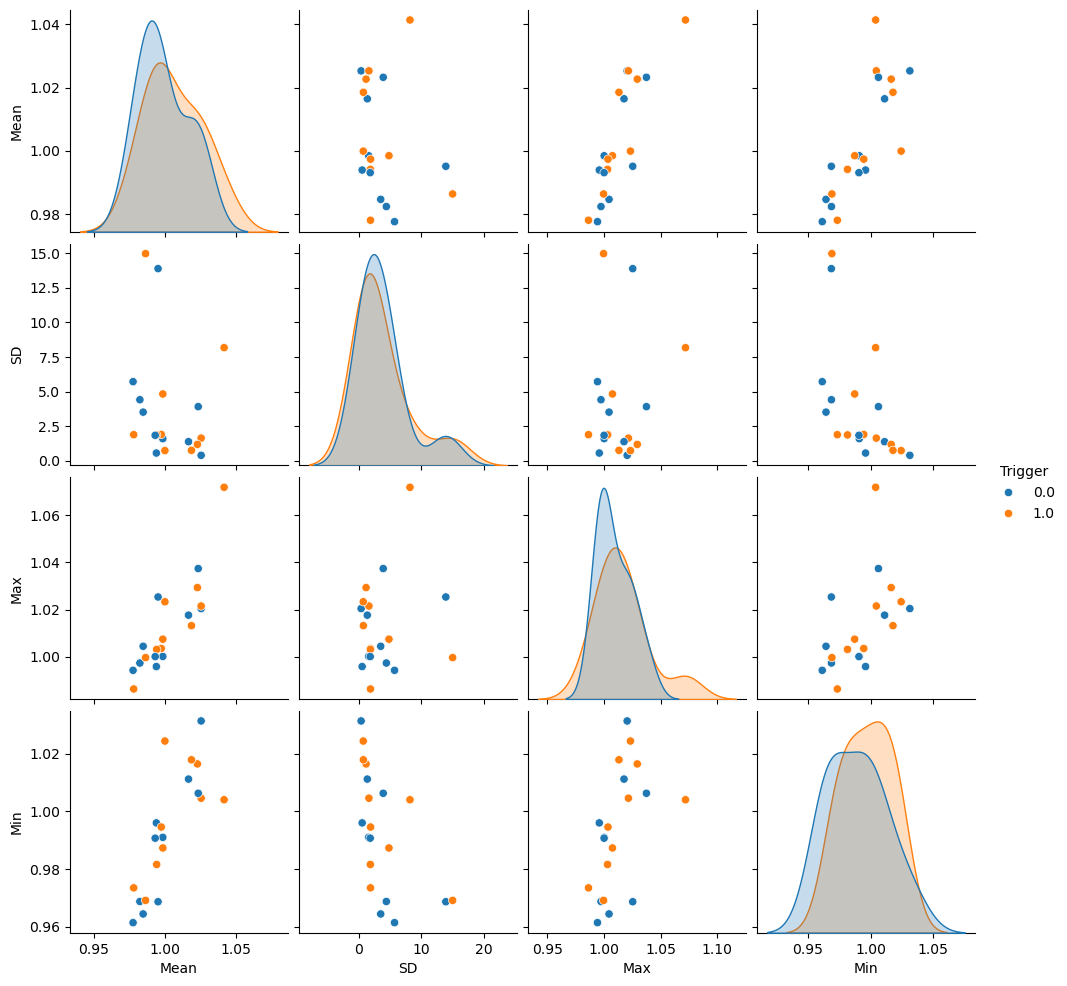

In [204]:
# show feature  grouped by trigger_values 0 and 1 using seaborn 
df = pd.DataFrame({'Mean': edaMean, 'SD': edaSD, 'Max': edaMax, 'Min': edaMin, 'Trigger': trigger_values})

sns.pairplot(df, hue='Trigger')
plt.show()

# ECG

In [205]:
ecg_cleaned = nk.ecg_clean(data['ECG'], sampling_rate=1000)

instant_peaks, rpeaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=1000)
_, waves_peak = nk.ecg_delineate(data['ECG'], rpeaks, sampling_rate=1000, method="peak")

rate = nk.ecg_rate(rpeaks, sampling_rate=1000, desired_length=len(ecg_cleaned))
quality = nk.ecg_quality(ecg_cleaned, sampling_rate=1000)


# Prepare output
signals = pd.DataFrame({"ECG_Raw": data['ECG'],
                        "ECG_Clean": ecg_cleaned,
                        "ECG_Rate": rate,
                        "ECG_Quality": quality})


signals = pd.concat([signals, instant_peaks], axis=1)

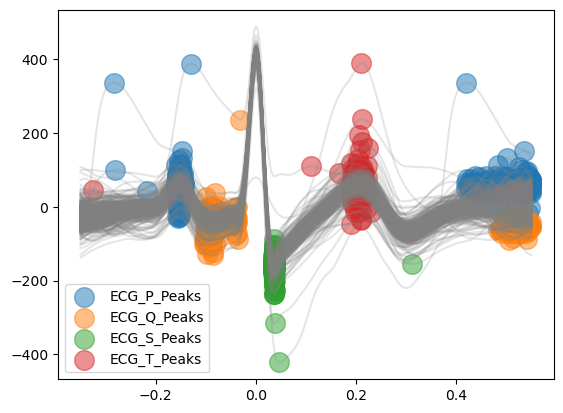

In [206]:
signal_dwt, waves_dwt = nk.ecg_delineate(signals, 
                                        rpeaks, 
                                        sampling_rate=1000, 
                                        method="dwt", 
                                        show=True, 
                                        show_type='peaks')

In [207]:
epochs=[]

# Process the data for event-related analysis
df, info = nk.bio_process(ecg=signals['ECG_Clean'], sampling_rate=1000)


events = nk.events_find(data["Trigger"], threshold=-1.0, event_conditions=trigger_values.values, threshold_keep='above')

epochs = nk.epochs_create(signals, events, sampling_rate=1000, epochs_start=-1.0, epochs_end=7.0)

# Analyze
analyze_epochs = nk.ecg_analyze(epochs, sampling_rate=1000)

# Get a dataframe with all the results

analyze_epochs

/Users/brunoleitao/anaconda3/envs/summerschool/lib/python3.10/site-packages/neurokit2/ecg/ecg_eventrelated.py:131: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/Users/brunoleitao/anaconda3/envs/summerschool/lib/python3.10/site-packages/neurokit2/ecg/ecg_eventrelated.py:131: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/Users/brunoleitao/anaconda3/envs/summerschool/lib/python3.10/site-packages/neurokit2/ecg/ecg_eventrelated.py:131: NeuroKitWarning: Input does not have an `ECG_Phase_Artrial` or `ECG_Phase_Ventricular` column. Will not indicate whether event onset concurs with cardiac phase.
  warn(
/Users/brunoleitao/anaconda3/envs/summerschool/lib/python3.10/site-packages/neurokit2/ecg/ecg_eventrelated.py:131: NeuroKitWarning: Input does not h

,Label,Condition,Event_Onset,ECG_Rate_Baseline,ECG_Rate_Max,ECG_Rate_Min,ECG_Rate_Mean,ECG_Rate_SD,ECG_Rate_Max_Time,ECG_Rate_Min_Time,ECG_Rate_Trend_Linear,ECG_Rate_Trend_Quadratic,ECG_Rate_Trend_R2,ECG_Quality_Mean
1,1,0.0,29000,73.097226,17.400512,-0.104525,10.162026,5.139858,6.549944,0.125141,3.727157,-0.000559,0.974801,0.943722
2,2,1.0,58000,84.106300,5.848723,-15.769170,-5.511410,8.504368,1.974372,5.989874,-2.362327,6.042288,0.809760,0.883125
3,3,0.0,86000,70.953300,13.316363,0.002412,6.075765,4.880304,5.069759,0.001125,2.172929,-1.695539,0.863002,0.906903
4,4,0.0,114000,81.279876,7.873170,-1.914797,2.493502,3.424158,6.893987,1.249281,0.396180,-1.668490,0.908194,0.786253
5,5,1.0,142000,73.781696,9.667539,0.006009,7.341350,1.907727,5.645831,0.001125,2.239505,3.641624,0.478363,0.978442
6,6,1.0,170000,81.251193,3.233669,-7.811780,-1.553819,3.338778,7.000000,5.638830,0.868478,-0.862210,0.258020,0.874650
7,7,0.0,198000,84.425009,2.911235,-7.304187,-3.898473,3.181278,6.142893,3.177522,-4.811674,0.462035,0.886145,0.903395
8,8,0.0,227000,78.186645,4.686283,-5.897489,-0.436957,3.011829,2.973497,6.093887,2.365963,-1.146159,0.664033,0.975643
9,9,1.0,255000,86.443683,1.275615,-4.811030,-0.832187,1.547883,1.275284,6.907988,1.211791,-1.181006,0.671386,0.928264
10,10,0.0,282000,81.273084,9.636007,-4.839963,3.169329,4.811497,2.296412,6.703963,1.632561,5.710355,0.787495,0.950514


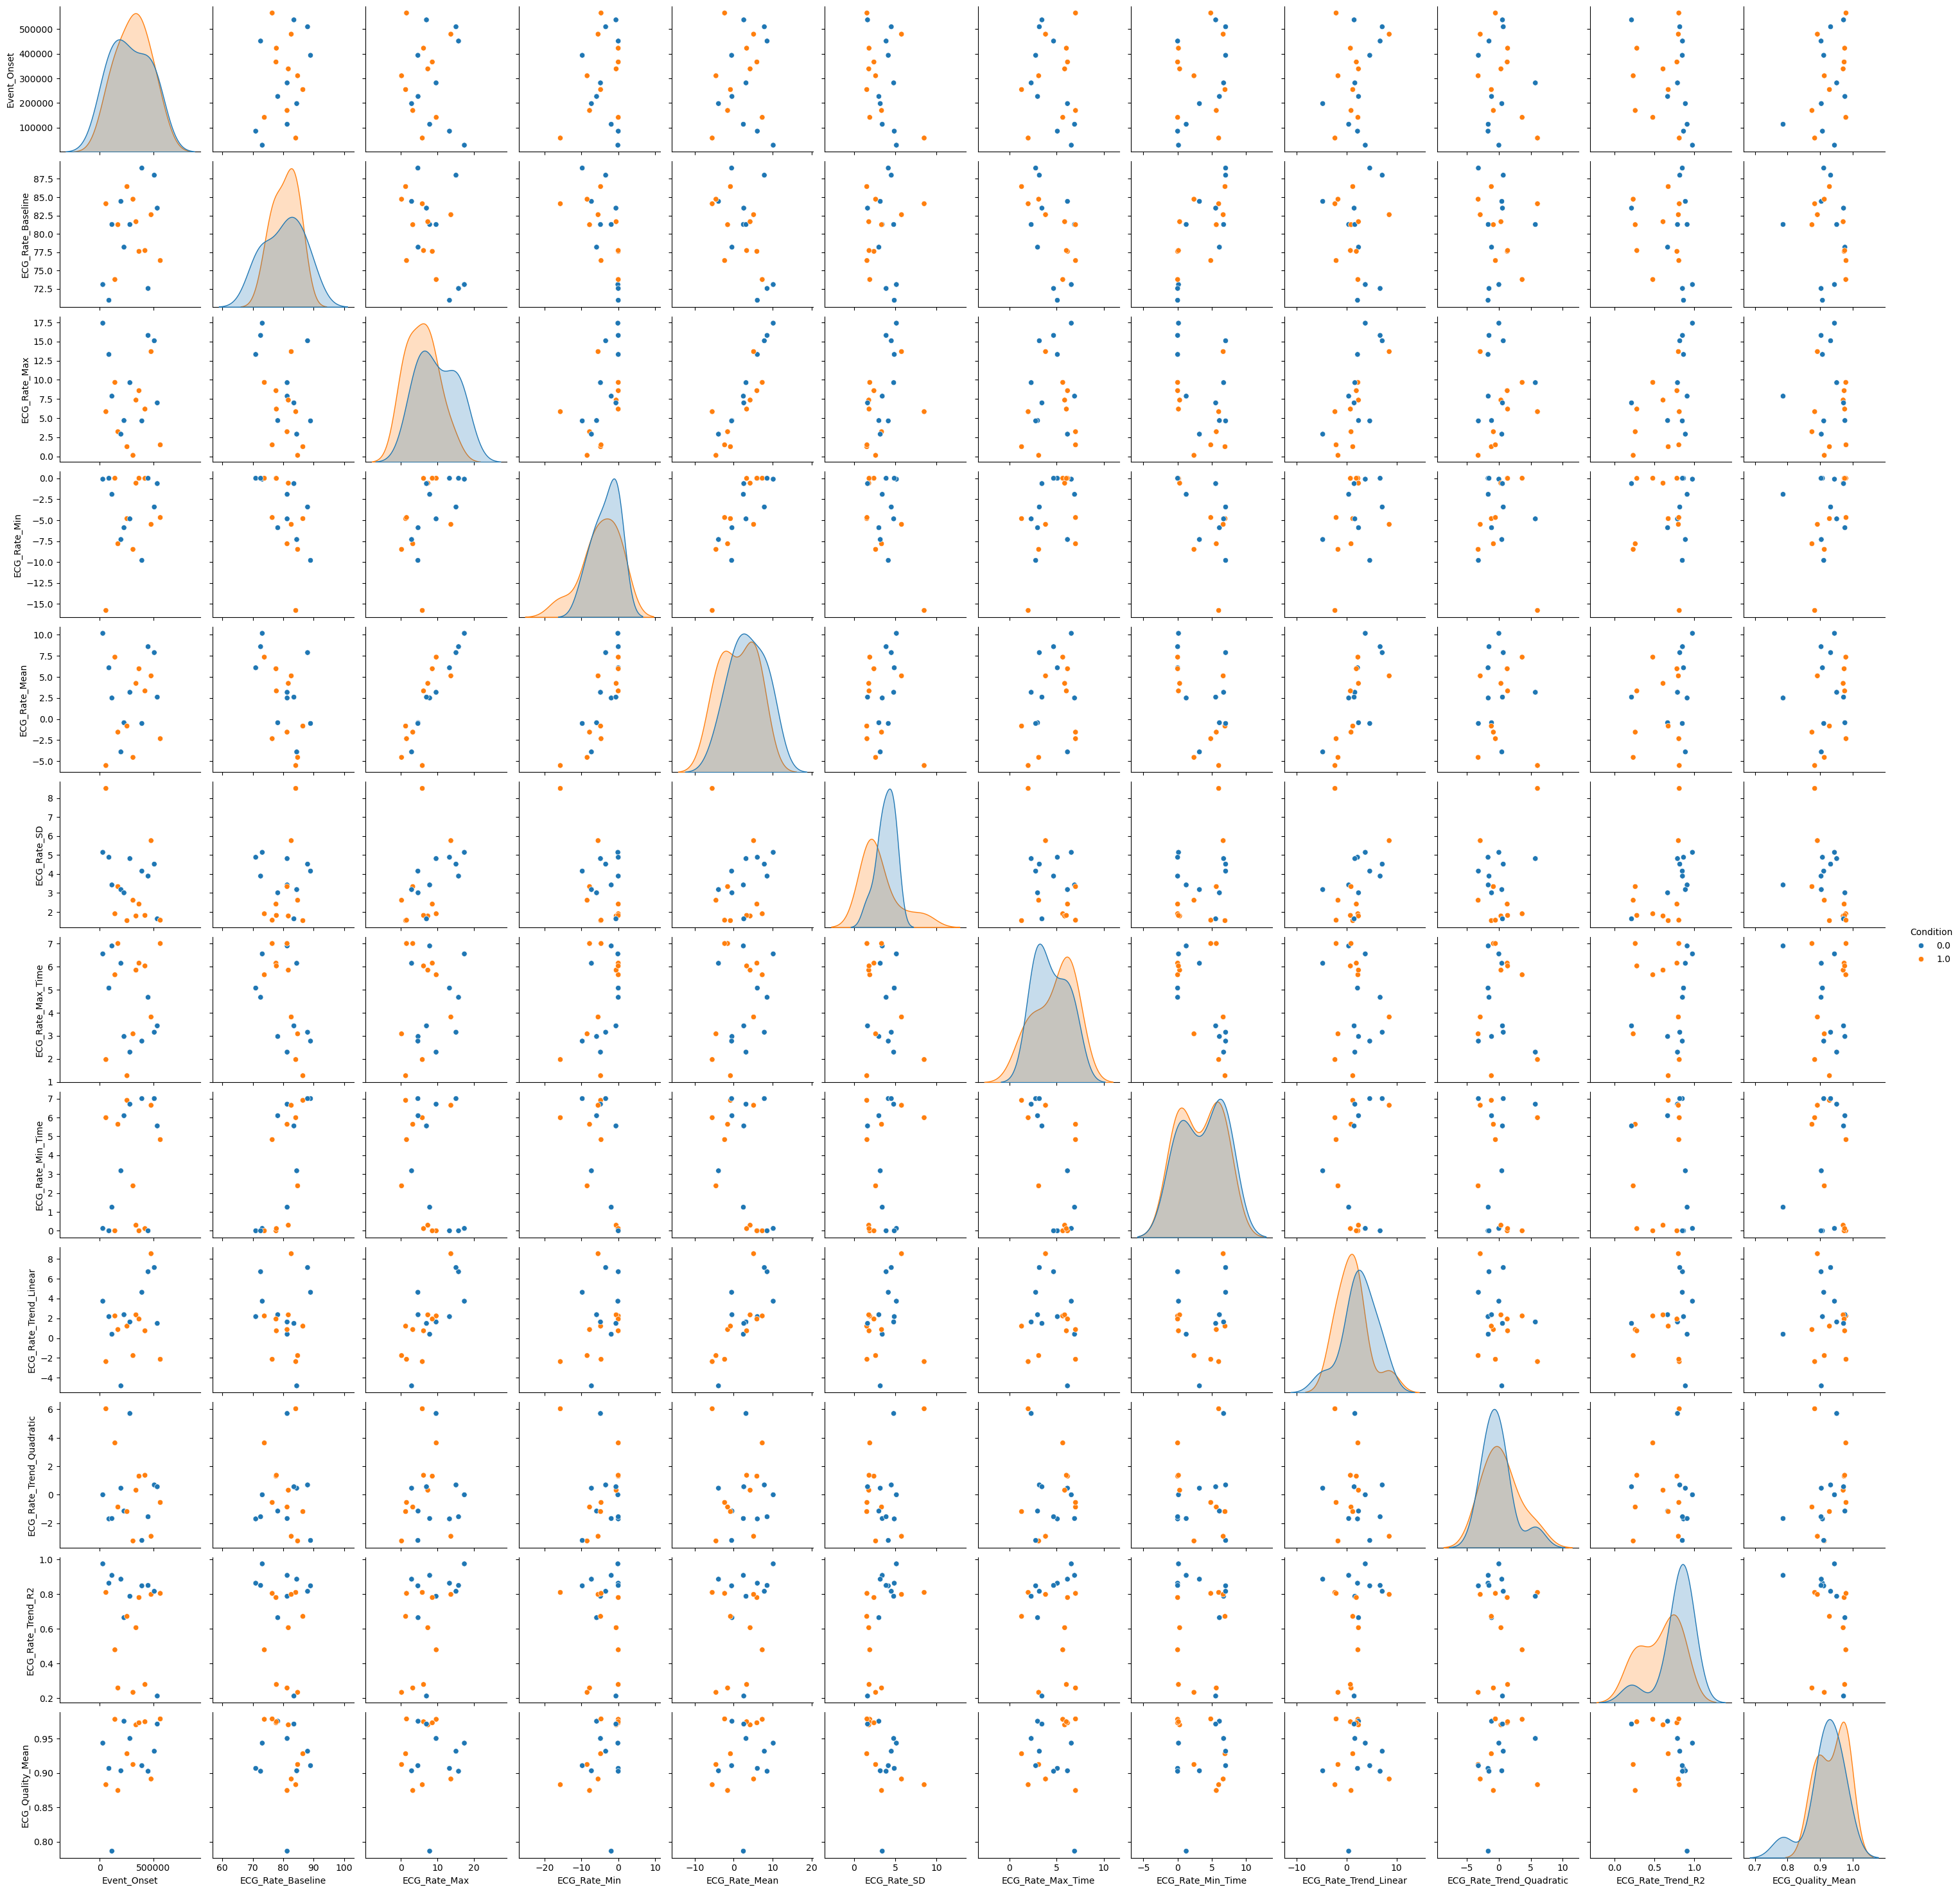

In [208]:
# show feature  grouped by trigger_values 0 and 1 using seaborn 


sns.pairplot(analyze_epochs, hue='Condition')
plt.show()

In [209]:
analyze_epochs.columns

Index(['Label', 'Condition', 'Event_Onset', 'ECG_Rate_Baseline',
       'ECG_Rate_Max', 'ECG_Rate_Min', 'ECG_Rate_Mean', 'ECG_Rate_SD',
       'ECG_Rate_Max_Time', 'ECG_Rate_Min_Time', 'ECG_Rate_Trend_Linear',
       'ECG_Rate_Trend_Quadratic', 'ECG_Rate_Trend_R2', 'ECG_Quality_Mean'],
      dtype='object')

<Axes: xlabel='Condition', ylabel='ECG_Rate_Max'>

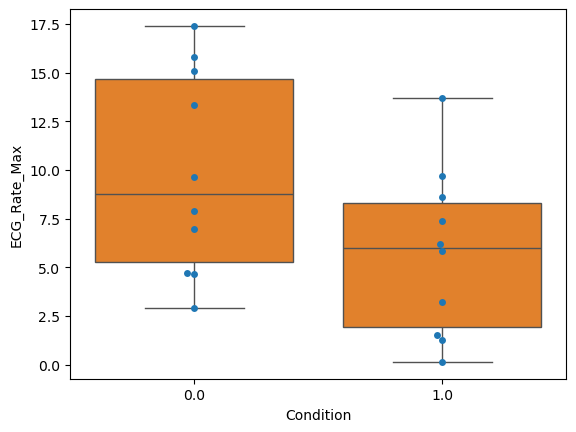

In [210]:
# show feature ECG_Rate_Baseline grouped by condition 0 and 1 using seaborn with points
#sns.swarmplot(x='Condition', y='ECG_Rate_Baseline', data=analyze_epochs)
#sns.boxplot(x='Condition', y='ECG_Rate_Baseline', data=analyze_epochs)



sns.swarmplot(x='Condition', y='ECG_Rate_Max', data=analyze_epochs)
sns.boxplot(x='Condition', y='ECG_Rate_Max', data=analyze_epochs)




# Classifier - decision tree and graph design

In [211]:
# Create array X with the features and array y with the target variable
X = analyze_epochs[['ECG_Rate_Baseline',
       'ECG_Rate_Max', 'ECG_Rate_Min', 'ECG_Rate_Mean', 'ECG_Rate_SD',
       'ECG_Rate_Max_Time', 'ECG_Rate_Min_Time', 'ECG_Rate_Trend_Linear',
       'ECG_Rate_Trend_Quadratic', 'ECG_Rate_Trend_R2', 'ECG_Quality_Mean']]

# Add coumns to X with the EDA features
X['EDA_Mean'] = edaMean
X['EDA_SD'] = edaSD
X['EDA_Max'] = edaMax
X['EDA_Min'] = edaMin

# Add column to X with the Resp features
X['Resp_Mean'] = rMean
X['Resp_SD'] = rSD
X['Resp_Max'] = rMax
X['Resp_Min'] = rMin


y = analyze_epochs['Condition']

/var/folders/nj/5_rdn90926779n4b6y3sbq9c0000gn/T/ipykernel_53961/2926054597.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['EDA_Mean'] = edaMean
/var/folders/nj/5_rdn90926779n4b6y3sbq9c0000gn/T/ipykernel_53961/2926054597.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['EDA_SD'] = edaSD


In [221]:

model = DecisionTreeClassifier(max_depth=7, random_state=0)

scores = cross_val_score(estimator=model, 
                         X=X,
                        y=y, 
                        cv=3,
                        scoring='accuracy')


print(scores, scores.mean())



[0.57142857 0.57142857 0.66666667] 0.6031746031746031


In [222]:
# Use svm as classifier
from sklearn.svm import SVC

svmmodel = SVC()

scores = cross_val_score(estimator=svmmodel,  
                         X=X,
                        y=y, 
                        cv=3,
                        scoring='accuracy') 

print(scores, scores.mean())

[0.42857143 0.42857143 0.5       ] 0.4523809523809524


In [223]:
model.fit(X, y)

DecisionTreeClassifier(max_depth=7, random_state=0)

In [224]:
model.predict(X)

array([0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.,
       0., 0., 1.])

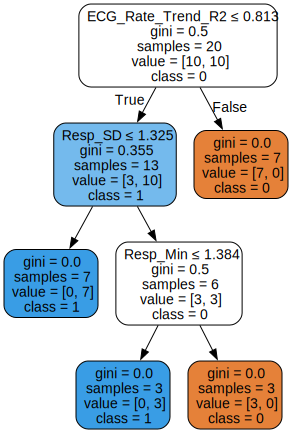

In [225]:

dot_data = tree.export_graphviz(model, 
                  feature_names=X.columns,
                  class_names=['0', '1'],
                  filled=True, 
                  rounded=True,  
                  special_characters=True,
                out_file=None,
                           )
graph = graphviz.Source(dot_data)
graph
